<a href="https://colab.research.google.com/github/kiharalab/DAQ-Refine/blob/main/DAQ_Refine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://user-images.githubusercontent.com/50850224/184964587-79a4e08d-4edd-4ef8-b69b-dfa8fe3b4804.png" align="left" style="height:240px">

#DAQ-refine: Protein Structure refinement by DAQ-score and ColabFold

This notebook contains a modified [ColabFold notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) and our tools.
To identify low quality regions in the protein structyure,
Please use [DAQ-score colab](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing)

Reference: [Terashi, G., Wang, X., Maddhuri Venkata Subramaniya, S.R. et al. Residue-wise local quality estimation for protein models from cryo-EM maps. Nat Methods (2022). https://doi.org/10.1038/s41592-022-01574-4](https://www.nature.com/articles/s41592-022-01574-4)


---
#Instructions
DAQ-refine has two strategies for the model refinement with DAQ-score.
###Before starting DAQ-refine, please use [**DAQ-score**](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing) on Google Colab, and then download a result file (**daq_score_w9.pdb**). DAQ-refine uses this **daq_score_w9.pdb** as a template structure.

##**Strategy-1: DAQ-score + ColabFold with a trimmed template model.**
You need: 
*   Output file of DAQ-score (**daq_score_w9.pdb**).

##**Strategy-2: DAQ-score + ColabFold with a trimmed template model + trimmed MSAs.**
You need: 
* Output file of DAQ-score (**daq_score_w9.pdb**).
* A MSA file (**A3M format**).
 * If you do not have a MSA file, please use `Vanilla AlphaFold2` or [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).

##After the ColabFold part, Rosetta relax protocol with the EM map will improve the model quality further.
* [Rosetta relax tutorial](https://www.rosettacommons.org/docs/latest/application_documentation/structure_prediction/relax)

* [Scripts and Tutorials](https://dimaiolab.ipd.uw.edu/software/)


#STEP-0 Install Dependencies

In [ ]:
#@title Install maxit (for converting fille format PDB to CIF)
#@markdown Just click `Run Cell` or `Ctr+Enter`
! wget https://sw-tools.rcsb.org/apps/MAXIT/maxit-v11.100-prod-src.tar.gz
! zcat maxit-v11.100-prod-src.tar.gz | tar -xf - 
#configure our environment 
import os
RCSBROOT=os.path.join(os.getcwd(),"maxit-v11.100-prod-src")
os.environ['RCSBROOT']=RCSBROOT
os.environ['PATH'] += ":RCSBROOT$/bin"
%cd maxit-v11.100-prod-src
! sudo apt-get install bison
! sudo apt-get install flex
! sudo apt-get install csh
! sudo apt install bash-completion
! ls binary.csh
! make binary
!csh binary.csh 
!./bin/DictToSdb -ddlFile ./data/ascii/mmcif_ddl.dic -dictFile ./data/ascii/mmcif_pdbx.dic -dictSdbFile mmcif_pdbx.sdb
!mv mmcif_pdbx.sdb ./data/binary
!rm -f ./bin/DictToSdb ./bin/cif2bin ./bin/connect_main
!csh 'if [ -e ./mmcif_pdbx.dic-parser.log ]; then rm -rf ./mmcif_pdbx.dic-parser.log; fi'
import os
cur_path=os.getcwd()
script_path = os.path.join(cur_path,"bin")
script_path = os.path.join(script_path,"maxit")
os.environ["maxit"]=script_path
%cd ..
# running command in this notebook : !$maxit -input xx.pdb -output xx.cif -o 1 or maxit -input xx.cif -output xx.pdb -o 2

--2022-08-17 22:12:44--  https://sw-tools.rcsb.org/apps/MAXIT/maxit-v11.100-prod-src.tar.gz
Resolving sw-tools.rcsb.org (sw-tools.rcsb.org)... 128.6.150.112
Connecting to sw-tools.rcsb.org (sw-tools.rcsb.org)|128.6.150.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75115767 (72M) [application/x-gzip]
Saving to: ‘maxit-v11.100-prod-src.tar.gz’

maxit-v11.100-prod- 100%[===================>]  71.64M  38.8MB/s    in 1.8s    

2022-08-17 22:12:46 (38.8 MB/s) - ‘maxit-v11.100-prod-src.tar.gz’ saved [75115767/75115767]

/content/maxit-v11.100-prod-src
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libbison-dev libsigsegv2 m4
Suggested packages:
  bison-doc m4-doc
The following NEW packages will be installed:
  bison libbi

<a name='step1'></a>
# STEP-1: Input Protein Sequence and DAQ result file

1. Select the DAQ-refine strategy:
* **Vanilla AlphaFold2** : does not use the DAQ-score result.
* **Strategy-1**: DAQ-score + ColabFold with a trimmed template model.
* **Strategy-2**: DAQ-score + ColabFold with a trimmed template model + trimmed MSAs.

2. **If you select Strategy-1 or -2**, upload a result file (**daq_score_w9.pdb**) generated by [DAQ-score colab](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing).

3. **If you select Strategy-2**, upload MSA file in **Input data** cell.

4. Runtime -> Run all


##Input data
<a name="template_mode"></a>

In [ ]:
#@title Input data
#@markdown Select strategy
from google.colab import files
import os
import os.path
import re
import hashlib
import random
import string

def TrimDAQ(filename,cutoff,outfile):
    daq=[]
    PDB={}
    lines=''
    with open(filename) as f:
        for li in f:
            #print(li)
            if li.startswith('ATOM'):
                li=li.strip()
                resn = int(li[23:27])
                sco = float(li[60:66])
                x = float(li[30:38])
                y = float(li[38:46])
                z = float(li[46:54])
                PDB[str(resn)]=[x,y,z,sco] 
                if sco < cutoff:
                    #print(sco)
                    daq.append(resn)
                else:
                    lines=lines+li+'\n'
    #print(lines)
    with open(outfile,'w') as out:
        out.write(lines)

rand_letters = string.ascii_lowercase
rand_letters = ''.join(random.choice(rand_letters) for i in range(20))
daq_file=''
str_mode = "strategy2" #@param ["Vanilla AF2","strategy1","strategy2"]
if str_mode == "strategy1" or str_mode == "strategy2":
  root_dir = os.getcwd()
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  print("Please Upload daq_score_w9.pdb (DAQ-score output file) HERE")
  pdb_input = files.upload()

  for fn in pdb_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(pdb_input[fn])))
    pdb_input_path = os.path.abspath(fn)
    print("PDB save to %s"%pdb_input_path)
    TrimDAQ(pdb_input_path,0.0,upload_dir+'/1tmp.pdb')
    #files.download(upload_dir+'/1tmp.pdb')
    #convert PDB to CIF
    !$maxit -input 1tmp.pdb -output 1tmp.cif -o 1 
    #files.download(upload_dir+'/1tmp.cif')
    daq_file=upload_dir+'/1tmp.cif'
  os.chdir(root_dir)
 

#@title Prepare a trimmed template model

##Use Colab Fold Part
from google.colab import files
import os.path
import re
import hashlib
import random

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#@markdown Input target sequence
query_sequence = 'MGEVTAEEVEKFLDSNVSFAKQYYNLRYRAKVISDLLGPREAAVDFSNYHALNSVEESEIIFDLLRDFQDNLQAEKCVFNVMKKLCFLLQADRMSLFMYRARNGIAELATRLFNVHKDAVLEECLVAPDSEIVFPLDMGVVGHVALSKKIVNVPNTEEDEHFCDFVDTLTEYQTKNILASPIMNGKDVVAIIMVVNKVDGPHFTENDEEILLKYLNFANLIMKVFHLSYLHNCETRRGQILLWSGSKVFEELTDIERQFHKALYTVRAFLNCDRYSVGLLDMTKQKEFFDVWPVLMGEAPPYAGPRTPDGREINFYKVIDYILHGKEDIKVIPNPPPDHWALVSGLPTYVAQNGLICNIMNAPSEDFFAFQKEPLDESGWMIKNVLSMPIVNKKEEIVGVATFYNRKDGKPFDEMDETLMESLTQFLGWSVLNPDTYELMNKLENRKDIFQDMVKYHVKCDNEEIQTILKTREVYGKEPWECEEEELAEILQGELPDADKYEINKFHFSDLPLTELELVKCGIQMYYELKVVDKFHIPQEALVRFMYSLSKGYRRITYHNWRHGFNVGQTMFSLLVTGKLKRYFTDLEALAMVTAAFCHDIDHRGTNNLYQMKSQNPLAKLHGSSILERHHLEFGKTLLRDESLNIFQNLNRRQHEHAIHMMDIAIIATDLALYFKKRTMFQKIVDQSKTYETQQEWTQYMMLDQTRKEIVMAMMMTACDLSAITKPWEVQSKVALLVAAEFWEQGDLERTVLQQNPIPMMDRNKADELPKLQVGFIDFVCTFVYKEFSRFHEEITPMLDGITNNRKEWKALADEYETKMKGLEEEKQKQQAANQAAAGSQHGGKQPGGGPASKSCCVQ' #@param {type:"string"}

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = '7jsnA' #@param {type:"string"}
# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"

# number of models to use
use_amber = False #@param {type:"boolean"}
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - This option is only active for Vanilla AF mode.
#@markdown - "none" = no template information is used, "pdb70" = detect templates in pdb70, "custom" - upload and search own templates (PDB or mmCIF format, see [notes below](#custom_templates))


if str_mode == "strategy1" or str_mode == "strategy2":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  #uploaded = files.upload()
  use_templates = True
  #for fn in uploaded.keys():
  fn = daq_file
  os.rename(fn, f"{jobname}_template/1tmp.cif")
  template_mode = "custom"
elif template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, f"{jobname}_template/{fn}")
else:
  custom_template_path = None
  use_templates = False

##MSA part##
def trim_a3m(a3m,daq,good):
    out=[]
    for ith in range(len(a3m)):
        name,seq = a3m[ith]
        new_seq=''
        if ith == 0:#query
            new_seq = seq
        else:
            pos=0
            for aa in seq:
                if aa == aa.lower() and aa != '-':
                    continue
                pos = pos + 1
                if pos in daq: #selected bad regions or missing regions
                    new_seq = new_seq + aa
                elif not pos in good:
                    new_seq = new_seq + aa
                elif aa == aa.upper():
                    new_seq = new_seq + '-'
        out.append([name,new_seq])
    return out

def ReadA3M(filename):
    A3M=[]
    with open(filename) as f:
        for li in f:
            if li.startswith('#'):
                continue
            if li.startswith('>'):
                name = li.strip()
            else:
                seq = li.strip()
                A3M.append([name,seq])
    return A3M

def ReadDAQ(filename,cutoff,dist_cut):
    daq=[]
    PDB={}
    with open(filename) as f:
        for li in f:
            #print(li)
            if li.startswith('ATOM') and li[13:16]=='CA ':
                li=li.strip()
                resn = int(li[23:27])
                sco = float(li[60:66])
                x = float(li[30:38])
                y = float(li[38:46])
                z = float(li[46:54])
                PDB[str(resn)]=[x,y,z,sco] 
                if sco < cutoff:
                    #print(sco)
                    daq.append(resn)
    print(daq)
    daq2=[]
    for resn in PDB:
        if int(resn) in daq:
            continue
        #Distance check
        x1=PDB[resn][0]
        y1=PDB[resn][1]
        z1=PDB[resn][2]
        for resn2 in PDB:
            if not int(resn2) in daq:
                continue
            x2=PDB[resn2][0]
            y2=PDB[resn2][1]
            z2=PDB[resn2][2]
            dist=(x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2)
            if dist <=dist_cut*dist_cut:#close
                daq2.append(int(resn))
                break
    #print('LowDAQ',daq,'Extended',daq2)
    daq=list(set(daq+daq2))
    #Others
    goodpos=[]
    for resn in PDB:
        if int(resn) in daq:
            continue
        goodpos.append(int(resn))
    print('HighDAQ',goodpos)
    
    return daq,goodpos

def save_a3m(file,a3m):
    lines=''
    for name,seq in a3m:
        lines = lines + name+'\n'
        lines = lines + seq+'\n'
    with open(file,'w') as out:
        out.write(lines)

#Use MSA
if str_mode == "strategy2":
  root_dir = os.getcwd()
  print(root_dir)
  print('Please upload MSA file (a3m format)')
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  cust_msa_input = files.upload()

  if not os.path.isfile(pdb_input_path):
    print('Can not find DAQ-score output file!!')


  for fn in cust_msa_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(cust_msa_input[fn])))
    cust_msa_path = os.path.abspath(fn)
    print("MSA save to %s"%cust_msa_path)
    a3m=ReadA3M(cust_msa_path)
    daq,good=ReadDAQ(pdb_input_path,0.0,0.0)
    new_a3m=trim_a3m(a3m,daq,good)
    filename=upload_dir+'/trimmed_msa.a3m'
    save_a3m(filename,new_a3m)
    daq_msa = filename
    #files.download(filename)
  os.chdir(root_dir)

Please Upload DAQ-score output file HERE


Saving dqa_score_w9.pdb to dqa_score_w9.pdb
User uploaded file "dqa_score_w9.pdb" with length 883462 bytes
PDB save to /content/bjulkcaapthjsdryafgt/dqa_score_w9.pdb


<a name='step2'></a>
#STEP-2: Modeling Part (by ColabFold)


### MSA options (custom MSA upload)
<a name="msa_options"></a>

In [ ]:

msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
pair_mode = "unpaired+paired" #@param ["unpaired+paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired+paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if str_mode == "strategy2":
  msa_mode = "custom"
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    #custom_msa_dict = files.upload()
    #custom_msa = list(custom_msa_dict.keys())[0]
    custom_msa = daq_msa
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
elif msa_mode.startswith("MMseqs2"):
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

moving /content/sssvonvfnluxaswgtifo/trimmed_msa.a3m to 3j6b9_b9d20.custom.a3m


## Advanced setting and Install dependencies

In [ ]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"]
num_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
#@markdown  - "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2". For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

In [ ]:
#@title Install dependencies
%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  #pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/kiharalab/ColabFoldDAQ"
  # high risk high gain
  pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

##Run Prediction
Ctr + Enter

2022-08-17 19:54:12,534 Found 4 citations for tools or databases
2022-08-17 19:54:19,309 Adding missing field revision_date to 3j6b9_b9d20_template/1tmp.cif. Backing up original file to 3j6b9_b9d20_template/1tmp.cif.bak.
2022-08-17 19:54:19,894 Query 1/1: 3j6b9_b9d20.custom (length 859)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


2022-08-17 19:54:30,631 Sequence 0 found templates: ['1tmp_A', '1tmp_A', '1tmp_A', '1tmp_A']
2022-08-17 19:54:31,470 Running model_1


/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


2022-08-17 20:13:35,206 model_1 took 1134.1s (3 recycles) with pLDDT 82.7 and ptmscore 0.593


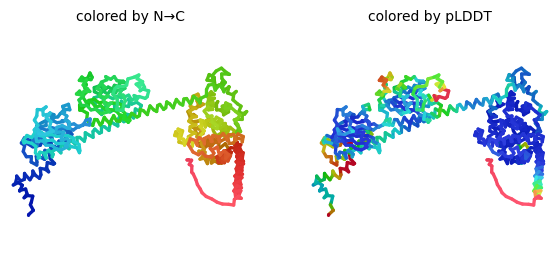

2022-08-17 20:14:52,861 Running model_2
2022-08-17 20:32:11,361 model_2 took 1031.8s (3 recycles) with pLDDT 82.6 and ptmscore 0.646


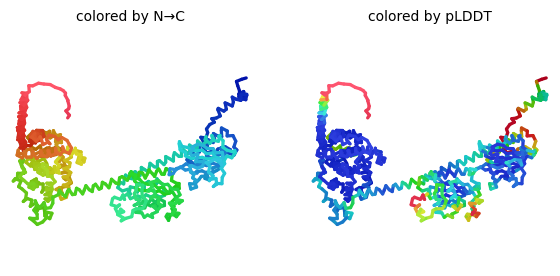

2022-08-17 20:33:28,458 Running model_3
2022-08-17 20:50:18,295 model_3 took 1003.8s (3 recycles) with pLDDT 41.5 and ptmscore 0.266


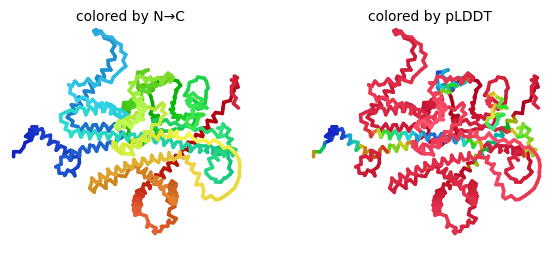

2022-08-17 20:51:36,622 Running model_4
2022-08-17 21:07:58,187 model_4 took 975.5s (3 recycles) with pLDDT 37.3 and ptmscore 0.245


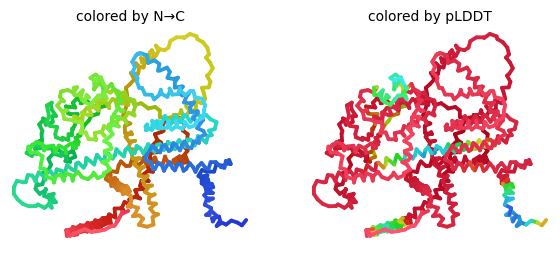

2022-08-17 21:09:14,468 Running model_5
2022-08-17 21:25:35,531 model_5 took 975.2s (3 recycles) with pLDDT 50.5 and ptmscore 0.387


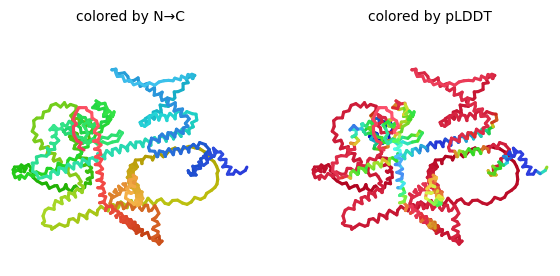

2022-08-17 21:26:52,439 reranking models by plddt


/usr/local/lib/python3.7/dist-packages/colabfold/plot.py:56: RuntimeWarning: All-NaN slice encountered
  lines_to_sort = lines_to_sort[np.argsort(-np.nanmax(lines_to_sort, axis=1))]


2022-08-17 21:26:59,807 Done


In [ ]:
#@title Run Prediction

import sys

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


# For some reason we need that to get pdbfixer to import
if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features, type):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=100)
  plt.show()
  plt.close()

result_dir="."
setup_logging(Path(".").joinpath("log.txt"))
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
download_alphafold_params(model_type, Path("."))
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    use_amber=use_amber,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
)

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

jobname_prefix = ".custom" if msa_mode == "custom" else ""
if use_amber:
  pdb_filename = f"{jobname}{jobname_prefix}_relaxed_rank_{rank_num}_model_*.pdb"
else:
  pdb_filename = f"{jobname}{jobname_prefix}_unrelaxed_rank_{rank_num}_model_*.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num,show_sidechains, show_mainchains, color).show()




You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


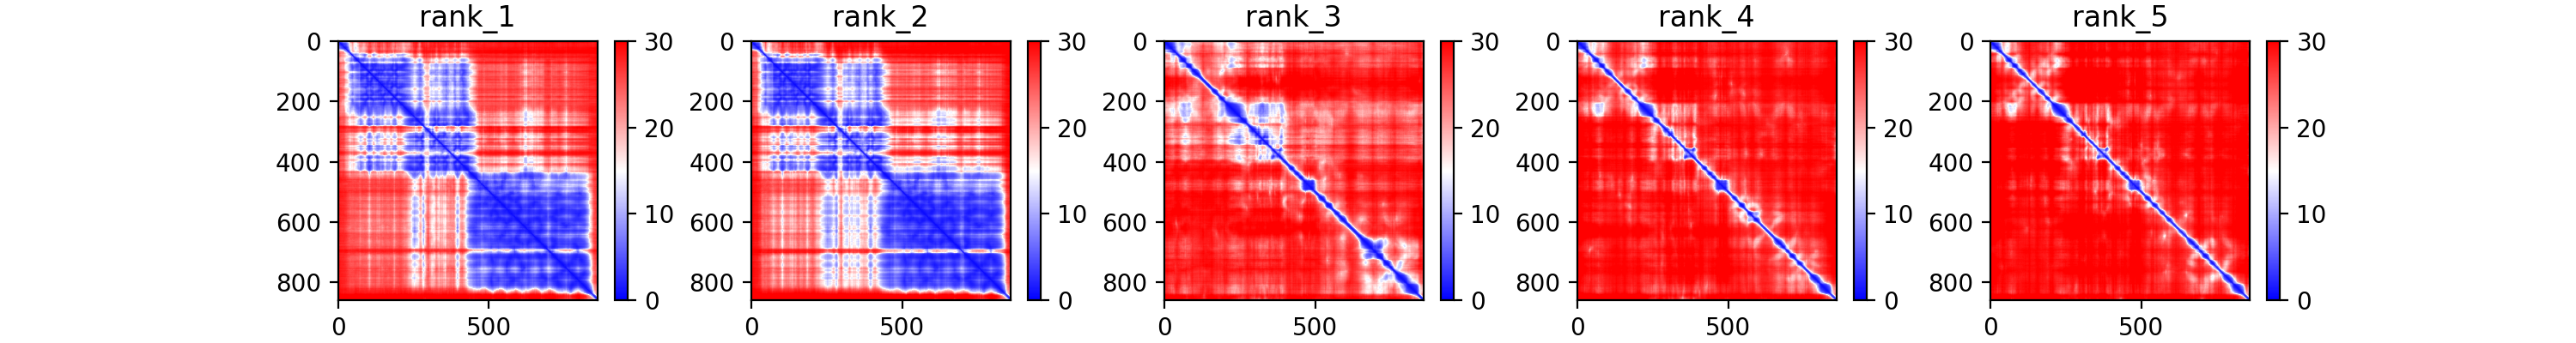
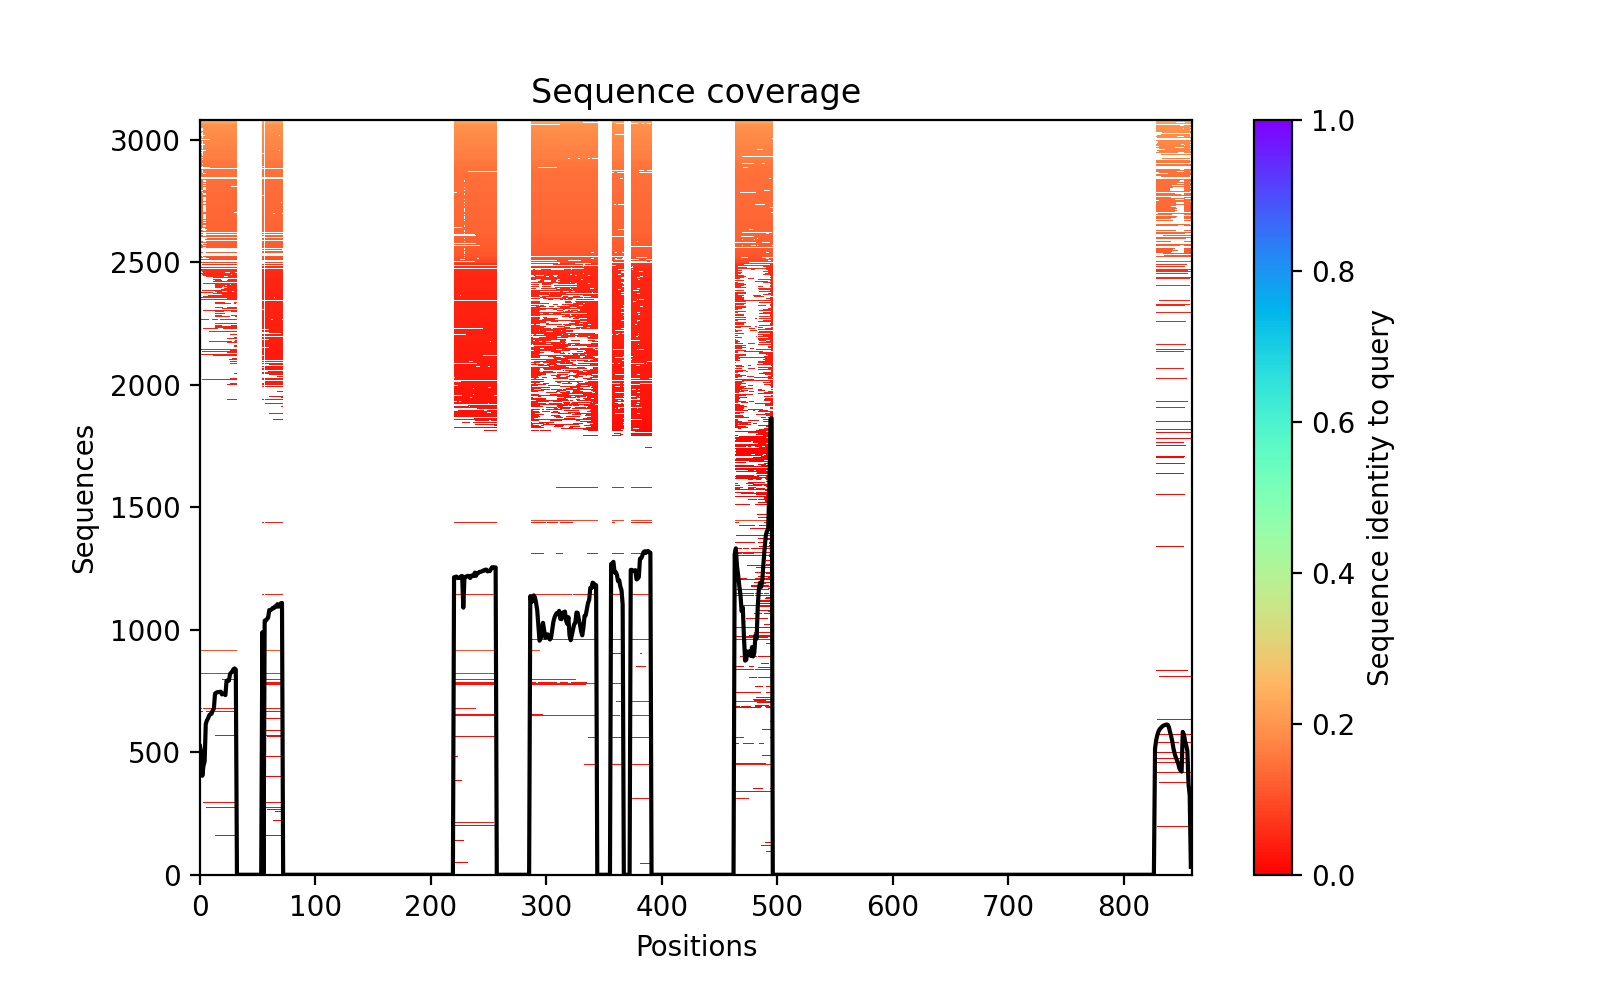
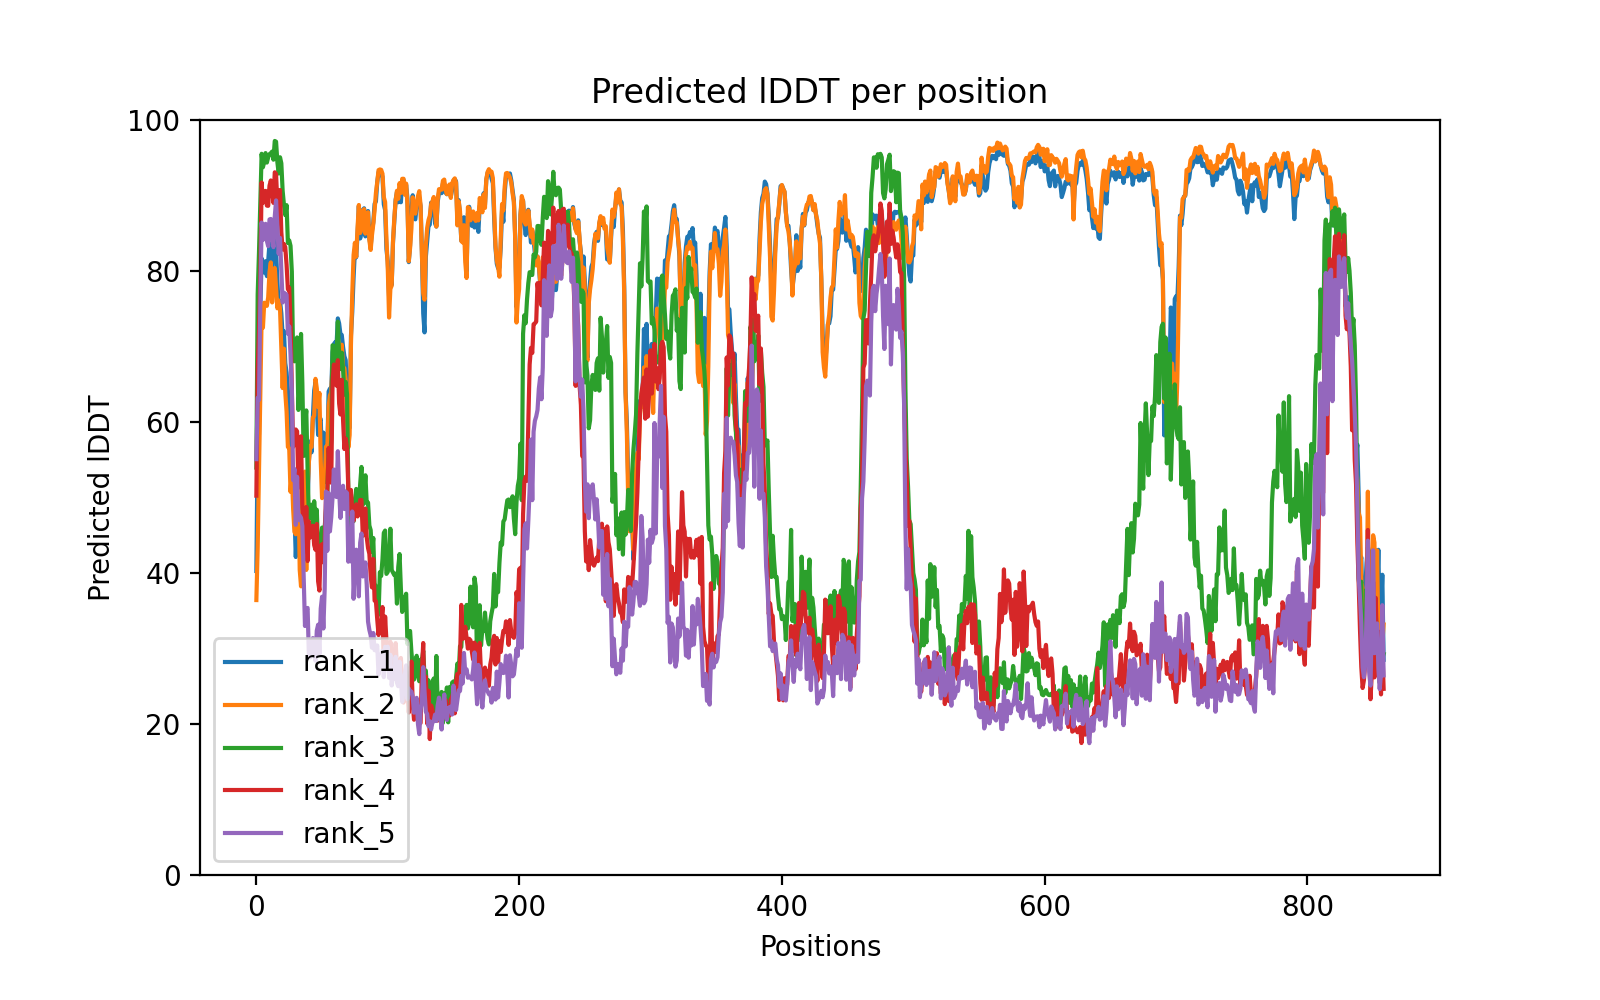

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(f"{jobname}{jobname_prefix}_PAE.png")
cov = image_to_data_url(f"{jobname}{jobname_prefix}_coverage.png")
plddt = image_to_data_url(f"{jobname}{jobname_prefix}_plddt.png")
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" config.json $jobname*".json" $jobname*".a3m" $jobname*"relaxed_rank_"*".pdb" "cite.bibtex" $jobname*".png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

Don't forget to cite your custom MSA generation method.
  adding: config.json (deflated 50%)
  adding: 3j6b9_b9d20.custom_predicted_aligned_error_v1.json (deflated 90%)
  adding: 3j6b9_b9d20.custom_template_domain_names.json (deflated 51%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_1_model_1_scores.json (deflated 70%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_2_model_2_scores.json (deflated 70%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_3_model_5_scores.json (deflated 72%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_4_model_3_scores.json (deflated 73%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_5_model_4_scores.json (deflated 73%)
  adding: 3j6b9_b9d20.custom.a3m (deflated 93%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_1_model_1.pdb (deflated 78%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_2_model_2.pdb (deflated 78%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_3_model_5.pdb (deflated 78%)
  adding: 3j6b9_b9d20.custom_unrelaxed_rank_4_model_3.pdb (deflated 78%)
  adding: 3j6b9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References

# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Detail Instructions of ColabFold part
- Please check [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)

**License**
The source code of DAQ-score and DAQ-refine are licensed under ***

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

